# Set up a regional MOM6 run within CESM framework (with CRR grid generation)

There are three main sections: 
1. First we create the MOM6 experiment using the [regional-mom6](https://github.com/COSIMA/regional-mom6/) package. This puts everything we need into two repositories, referred to as the `mom_run_dir` and `mom_input_dir`. These contain all of the configuration files (`MOM_input` etc.) and netcdf input files (`hgrid.nc`, OBC segments etc.) respectively. An `experiment` object is also created within the notebook, containing all the information we need about the regional mom6 setup to pass onto CESM.

2. A new MOM6 CESM case is created in the usual way by cloning the CESM repo and running the `create_case` command. 

3. We modify the new CESM case to work with the regional mom6 configuration we prepared earlier. We pass the path to this CESM run and the experiment object to the `setup_cesm` function, which carries out all the required modifications 

This is very much a work in progress! The goal in the short term was to get something working and make it nice later

# SECTION 1: Setup up you MOM6 regional experiment

This follows the normal workflow, copied from the `reanalysis_forced.ipynb` demo of [regional-mom6](https://github.com/COSIMA/regional-mom6/) but modified for a domain around Hawaii. See the documentation of the package for details and documentation

In [1]:
import os
from pathlib import Path
import sys

In [2]:
import crocodileregionalruckus as crr
from crocodileregionalruckus.rm6 import regional_mom6 as rmom6

## Step 1: Choose our domain, define workspace paths

To make sure that things are working I'd recommend starting with the default example defined below. If this runs ok, then change to a domain of your choice and hopefully it runs ok too! If not, check the [README](https://github.com/COSIMA/regional-mom6/blob/main/README.md) and [documentation](https://regional-mom6.readthedocs.io/) for troubleshooting tips.

You can log in and use [this GUI](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/download) to find the lat/lon of your domain and copy paste below.

In [7]:
expt_name = "crr-sub-glob-fresh-hawaii-t2"

latitude_extent = [16., 27]
longitude_extent = [192, 209]

date_range = ["2020-01-01 00:00:00", "2020-02-01 00:00:00"]

## Place where all your input files go 
input_dir = Path(f"/glade/u/home/manishrv/documents/nwa12_0.1/mom_input/{expt_name}/")

## Directory where you'll run the experiment from
run_dir = Path(f"/glade/u/home/manishrv/documents/nwa12_0.1/mom_run/{expt_name}/")

## Directory where compiled FRE tools are located (needed for construction of mask tables)
toolpath_dir = Path("")

## Path to where your raw ocean forcing files are stored
glorys_path = os.path.join("/","glade","derecho","scratch","manishrv","inputs_rm6_hawaii","glorys" )

## if directories don't exist, create them
for path in (run_dir, glorys_path, input_dir):
    os.makedirs(str(path), exist_ok=True)

## Step 1.5: Grid Generation

In [8]:
# Create the grid gen object
grid_gen_obj = crr.grid_gen.GridGen() 

In [10]:
# Create Hgrid
subset_global_hgrid = grid_gen_obj.subset_global_hgrid(longitude_extent = longitude_extent, latitude_extent = latitude_extent)

# Create Vgrid
gen_vgrid = grid_gen_obj.create_vgrid(75,10,depth = 4500, minimum_depth = 25)

# Move desired hgrid, and vgrid to mom_input with the filenames that regional mom6 recognizes
subset_global_hgrid.to_netcdf(input_dir / "hgrid.nc")
gen_vgrid.to_netcdf(input_dir / "vcoord.nc")

## Step 2: Make experiment object
The `regional_mom6.experiment` contains the regional domain basics, and also generates the horizontal and vertical grids, `hgrid` and `vgrid` respectively, and sets up the directory structures. 

In [11]:
expt = rmom6.experiment(
    longitude_extent = longitude_extent,
    latitude_extent = latitude_extent,
    date_range = date_range,
    resolution = 0.05,
    number_vertical_layers = 75,
    layer_thickness_ratio = 10,
    depth = 4500,
    minimum_depth = 25,
    mom_run_dir = run_dir,
    mom_input_dir = input_dir,
    toolpath_dir = toolpath_dir,
    hgrid_type = "from_file", # This is how we incorporate the grid_gen files
    vgrid_type = "from_file",
    expt_name = expt_name,
        boundaries=["north", "south", "east", "west"]
)

## Step 3: Prepare ocean forcing data

We need to cut out our ocean forcing. The package expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is `"east_unprocessed"` for segments and `"ic_unprocessed"` for the initial condition.

In this notebook, we are forcing with the Copernicus Marine "Glorys" reanalysis dataset. There's a function in the `mom6-regional` package that generates a bash script to download the correct boundary forcing files for your experiment. First, you will need to create an account with Copernicus, and then call `copernicusmarine login` to set up your login details on your machine. Then you can run the `get_glorys_data.sh` bash script.

The function is called `get_glorys_rectangular` because the fully automated setup is only supported for domains with boundaries parallel to lines of longitude and latitude. To download more complex domain shapes you can call `rmom6.get_glorys_data` directly.

In [6]:
expt.get_glorys_rectangular(
    raw_boundaries_path=glorys_path,

)

script `get_glorys_data.sh` has been created at /glade/work/manishrv/inputs_rm6/pan-demo-crr.
 Run this script via bash to download the data from a terminal with internet access. 
You will need to enter your Copernicus Marine username and password.
If you don't have an account, make one here:
https://data.marine.copernicus.eu/register


## Step 4: Set up bathymetry with grid gen

Similarly to ocean forcing, we point the experiment's `setup_bathymetry` method at the location of the file of choice and also provide the variable names. We don't need to preprocess the bathymetry since it is simply a two-dimensional field and is easier to deal with. Afterwards you can inspect `expt.bathymetry` to have a look at the regional domain.

After running this cell, your input directory will contain other bathymetry-related things like the ocean mosaic and mask table too. The mask table defaults to a 10x10 layout and can be modified later.

In [12]:
expt.bathymetry = grid_gen_obj.subset_global_topo(longitude_extent, latitude_extent)


# Move to MOM Input Directory
expt.bathymetry.to_netcdf(input_dir / "bathymetry.nc")


### Check out your domain:

In [13]:
import matplotlib.pyplot as plt
import xarray as xr
expt.bathymetry = xr.open_dataset("/glade/u/home/manishrv/documents/nwa12_0.1/mom_input/crr-sub-glob-fresh-hawaii/bathymetry.nc")


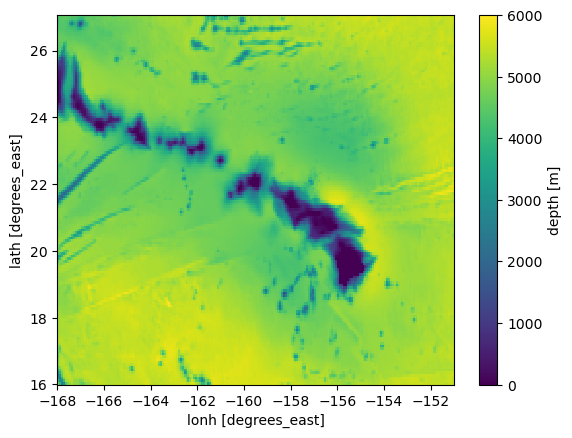

In [14]:
expt.bathymetry.depth.plot()

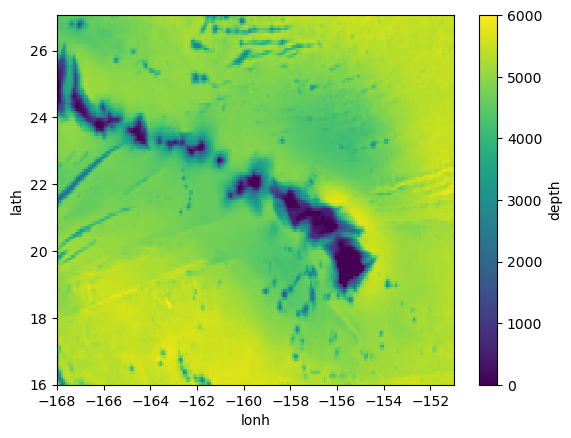

In [17]:
# Then mask out parts of the domain we don't want by selecting a point in the ocean domain we do want.
temp = grid_gen_obj.mask_disconnected_ocean_areas(hgrid = expt.hgrid, topo = expt.bathymetry.depth, name_x_dim = "x", name_y_dim = "y", lat_pt = 20, lon_pt = 200)
#expt.bathymetry.to_netcdf(expt.mom_input_dir / "bathymetry.nc")
temp.depth.plot()
expt.bathymetry = temp

##  Step 5: Handle the ocean forcing - where the magic happens

This cuts out and interpolates the initial condition as well as all boundaries (unless you don't pass it boundaries).

The dictionary maps the MOM6 variable names to what they're called in your ocean input file. Notice how for GLORYS, the horizontal dimensions are `latitude` and `longitude`, vs `xh`, `yh`, `xq`, `yq` for MOM6. This is because for an 'A' grid type tracers share the grid with velocities so there's no difference.

If one of your segments is land, you can delete its string from the 'boundaries' list. You'll need to update MOM_input to reflect this though so it knows how many segments to look for, and their orientations.

In [18]:
# Define a mapping from the GLORYS variables and dimensions to the MOM6 ones
ocean_varnames = {"time": "time",
                  "yh": "latitude",
                  "xh": "longitude",
                  "zl": "depth",
                  "eta": "zos",
                  "u": "uo",
                  "v": "vo",
                  "tracers": {"salt": "so", "temp": "thetao"}
                  }

# Set up the initial condition
expt.setup_initial_condition(
    Path(glorys_path) / "ic_unprocessed.nc", # directory where the unprocessed initial condition is stored, as defined earlier
    ocean_varnames,
    arakawa_grid="A"
    )    

# Set up the four boundary conditions. Remember that in the glorys_path, we have four boundary files names north_unprocessed.nc etc. 
expt.setup_ocean_state_boundaries(
        Path(glorys_path),
        ocean_varnames,
        arakawa_grid = "A"
        )

INITIAL CONDITIONS
Regridding Velocities... Done.
Regridding Tracers... Done.
Regridding Free surface... Done.
Saving outputs... done setting up initial condition.
[########################################] | 100% Completed | 101.94 ms
Done.
[########################################] | 100% Completed | 102.02 ms
Done.
[########################################] | 100% Completed | 101.84 ms
Done.
[########################################] | 100% Completed | 101.96 ms
Done.


In [ ]:
# Setup the tides!
expt.setup_boundary_tides(Path("/glade/u/home/manishrv/manish_scratch_symlink/inputs_rm6/tidal_data/h_tpxo9.v1.nc"),Path("/glade/u/home/manishrv/manish_scratch_symlink/inputs_rm6/tidal_data/u_tpxo9.v1.nc"),    tidal_constituents=[ "M2",        "S2",        "N2",        "K2",        "K1",        "O1",        "P1",        "Q1",        "MM",        "MF"])

## Step 6: Modify the default input directory to make a (hopefully) runnable configuration out of the box

This step copies the default directory and modifies the `MOM_layout` files to match your experiment by inserting the right number of x, y points and CPU layout.

To run MOM6 using the [payu infrastructure](https://github.com/payu-org/payu), provide the keyword argument `using_payu = True` to the `setup_run_directory` method and an example `config.yaml` file will be appear in the run directory. The `config.yaml` file needs to be modified manually to add the locations of executables, etc.

In [22]:
expt.setup_run_directory(surface_forcing = "jra")

Could not find premade run directories at  /glade/u/home/manishrv/documents/nwa12_0.1/regional_mom_workflows/rm6/regional-mom6/regional_mom6/demos/premade_run_directories
Perhaps the package was imported directly rather than installed with conda. Checking if this is the case... 
Found run files. Continuing...
At least one of these is requiret to set up the experiment if you're running MOM6 standalone with the FMS coupler. 
If you're running within CESM, ignore this message.
Deleting indexed OBC keys from MOM_input_dict in case we have a different number of segments


In [35]:
expt.change_MOM_parameter("MINIMUM_DEPTH","9.95")

This parameter MINIMUM_DEPTH is begin replaced from 9.45 to 9.95 in MOM_override
Changed MINIMUM_DEPTH from {'value': '9.45', 'override': True, 'comment': 'None#override NK = 75 '} to {'value': '9.95', 'override': True, 'comment': None} in MOM_override!


'9.45'

# SECTION 2: Create a blank CESM run

So far I've used Alper's [GUI](https://github.com/ESMCI/visualCaseGen?tab=readme-ov-file) branch of CESM. Clone respective branch of CESM and then run the generate case command. Below is the command I used to generate a global, MOM6 only run forced with JRA data atmosphere

`/glade/u/home/abarnes/cesm-runs/visualCaseGen/cesm2_3_beta17_gui/cime/scripts/create_newcase --compset 1850_DATM%JRA_SLND_SICE_MOM6_SROF_SGLC_SWAV --res TL319_t232 --case /glade/u/home/manishrv/cases/crr-sub-glob-fresh-hawaii --machine derecho --run-unsupported --project p93300012 --non-local`

In [36]:
# Save the path where the new CESM config lives
CESM_path = Path(f"/glade/u/home/manishrv/cases/crr-sub-glob-fresh-hawaii-t2")

# SECTION 3: Modify the CESM run to make it regional

In [37]:
## Regional CaseGen is part of crr

reg_cas_obj = crr.regional_casegen.cesm_tools.RegionalCaseGen()


reg_cas_obj.setup_cesm(expt, CESM_path, project = "p93300612")
## OR you can explicitly state what variables are needed
# reg_cas_obj.setup_cesm_explicit(hgrid = expt.hgrid, CESMPath = CESM_path,project = "p93300612", mom_input_dir=expt.mom_input_dir, mom_run_dir=expt.mom_run_dir,date_range = expt.date_range)

Copying input.nml, diag_table, MOM_input_and MOM_override to /glade/u/home/manishrv/cases/crr-sub-glob-fresh-hawaii/SourceMods/src.mom
Adding NIGLOBAL = 204, NJGLOBAL = 143, and INPUTDIR = /glade/u/home/manishrv/documents/nwa12_0.1/mom_input/crr-sub-glob-fresh-hawaii to MOM_override
Removing references to MOM_layout in input.nml
Add MOM_override to parameter_filename in input.nml
Move all of the forcing files out of the forcing directory to the main inputdir
Find and replace instances of forcing/ with nothing in the MOM_input file
Find and replace instances of forcing/ with nothing in the MOM_input file
Make ESMF grid and save to inputdir
Make xml changes. Setting OCN_NX=204, OCN_NY=143
MOM6_MEMORY_MODE=dynamic_symmetric
OCN_DOMAIN_MESH, ICE_DOMAIN_MESH, MASK_MESH, MASK_GRID, OCN_GRID, ICE_GRID =/glade/u/home/manishrv/documents/nwa12_0.1/mom_input/crr-sub-glob-fresh-hawaii/esmf_mesh.nc
RUN_REFDATE, RUN_STARTDATE = 2020-01-01
For your changes to take effect, run:
./case.build --clean-al

Now hopefully doing the usual 

`./case.setup && ./case.build && ./case.submit` 

should at least run. Of course from here you'll have a lot of other things to fiddle around with to make it run *well!* 